# Data Importation

In [1]:
! pip install pyspark
! pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 52 kB/s 
     |████████████████████████████████| 199 kB 45.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=20747998517b6212ce1c156897ebe8a5fe49248530034d1ebab34daf396132fd
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as f
from pyspark.sql.functions import *
from pyspark import sql
from pyspark.sql.types import *

def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc

spark, sc = init_spark('demo')
sc
fix_atributes = re.compile(",")

In [41]:
data = spark.read.json("data.json").filter(f.col("gt") != 'null')
data = data.withColumn("Arrival_time_sec", data.Arrival_Time / 10**3).withColumn("Creation_time_sec", data.Creation_Time / 10**9).drop("Arrival_Time", "Creation_Time")
data = data.withColumn("Arrival_time_date", f.from_unixtime(data.Arrival_time_sec)).withColumn("Creation_time_date", f.from_unixtime(data.Creation_time_sec))

In [42]:
N_data = data.drop("Model", "Index") 
coordinates_data = N_data.drop("Arrival_time_sec", "Creation_time_sec", "Arrival_time_date", "Creation_time_date")
time_data = N_data.drop('x', 'y', 'z')


In [18]:
data_csv = pd.read_json('data.json', lines='True')
data_csv.to_csv('data_csv.csv', index=False)

In [19]:
datacsv = spark.read.format('csv').option("header", "true").load('data_csv.csv')

# Data Analysis

1. **Pairs of (User,Gt) most popular**

In [20]:
datacsv.createOrReplaceTempView("testTable")
sqlDF = spark.sql("SELECT User,gt, count(gt,User) as Counter FROM testTable GROUP BY User,gt SORT BY Counter DESC")
sqlDF.show()

+----+-----+-------+
|User|   gt|Counter|
+----+-----+-------+
|   g| null|  12254|
|   e| null|  12222|
|   b| walk|  11347|
|   b| bike|  11192|
|   g| walk|  11098|
|   e| walk|  11060|
|   d| walk|  10840|
|   i| walk|  10787|
|   f| walk|  10612|
|   h|  sit|  10519|
|   a|  sit|  10458|
|   i|  sit|  10243|
|   e| bike|  10136|
|   g|  sit|  10087|
|   a|stand|   9793|
|   e|  sit|   9758|
|   b| null|   9654|
|   f| null|   9618|
|   c| walk|   9604|
|   f| bike|   9443|
+----+-----+-------+
only showing top 20 rows



This allows us to learn about the activities that each user is more likely to do (based on the number of samples of each activity).
For example, user b is the user that walk and ride a bike the most.

2.1 **Repartition of the (x,y,z) coordinates**

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

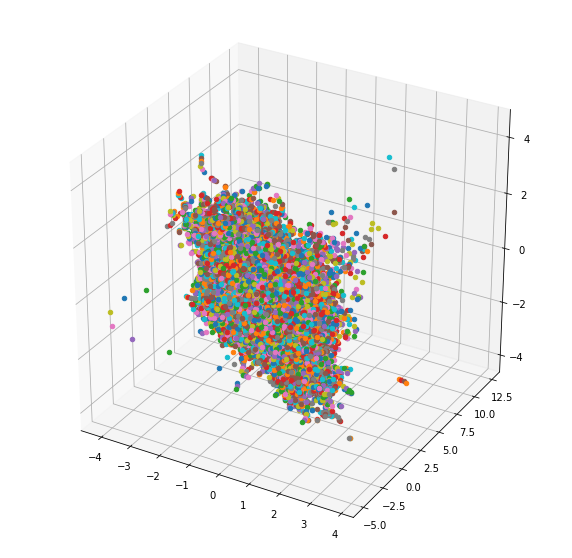

In [3]:
import pandas as pd
import numpy as np
import os

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
xs=[]
ys=[]
zs=[]
data = pd.read_csv("data_csv.csv")
for i in range(546083):
  xs.append(data.iloc[i,7])
  ys.append(data.iloc[i,8])
  zs.append(data.iloc[i,9])
for i in range(546083):
  ax.scatter(xs[i],ys[i],zs[i])

plt.show()

This 3D graph shows us that althought that each sample have his particular coordinates, all these points are present in the same area of values and aren't a lot scattered in all the axes. We will see in details for example that all the x values are situated between -4 and 3 (rounded values). 

2.2 **Relation between the (x,y,z) coordinates and the "gt" activities**

In [43]:
def plot(values, axis, in_color='yellow', with_width = 0.75, with_label='graph', size='s'):
  bar = np.arange(len(values))
  if size=='m':
    fig = plt.subplots(figsize =(12, 3)) 
  if size == 'l':
    fig = plt.subplots(figsize =(24, 3)) 
  plt.bar(bar, values, color=in_color, width=with_width, edgecolor='grey', label=with_label)
  plt.xticks([i + 0.1 for i in range(len(axis))], axis)
  plt.title(with_label)
  plt.show()
  print()

In [44]:
def values_list(row_list):
  list_len = len(row_list)
  return [row_list[i][0] for i in range(list_len)]

In [45]:
x_max = coordinates_data.agg({"x": "max"}).collect()[0][0]
x_min = coordinates_data.agg({"x": "min"}).collect()[0][0]
y_max = coordinates_data.agg({"y": "max"}).collect()[0][0]
y_min = coordinates_data.agg({"y": "min"}).collect()[0][0]
z_max = coordinates_data.agg({"z": "max"}).collect()[0][0]
z_min = coordinates_data.agg({"z": "min"}).collect()[0][0]

In [46]:
activities = values_list(list(set(data.select("gt").collect())))

In [47]:
print(x_max, x_min, y_max, y_min, z_max, z_min)

3.0051422 -4.128174 12.35347 -5.0084076 4.3583984 -4.038849


Give us the exacts areas of values of each axe.

X Coordinates:



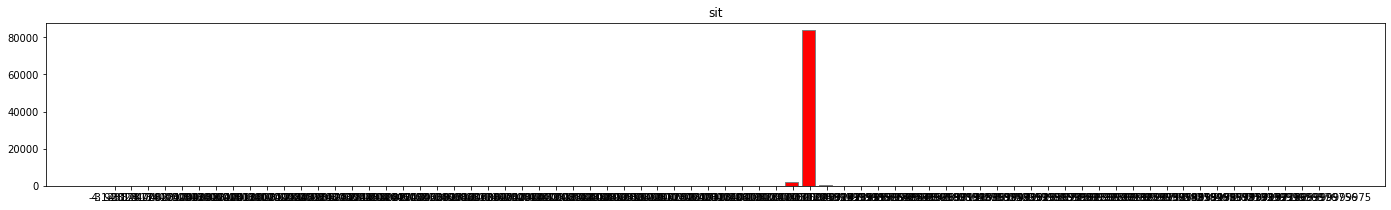

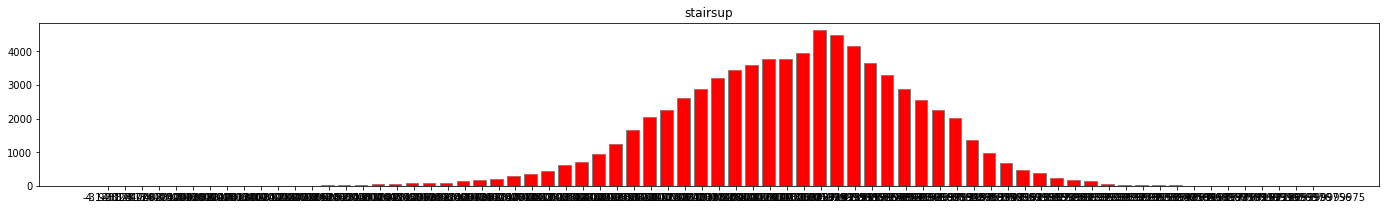

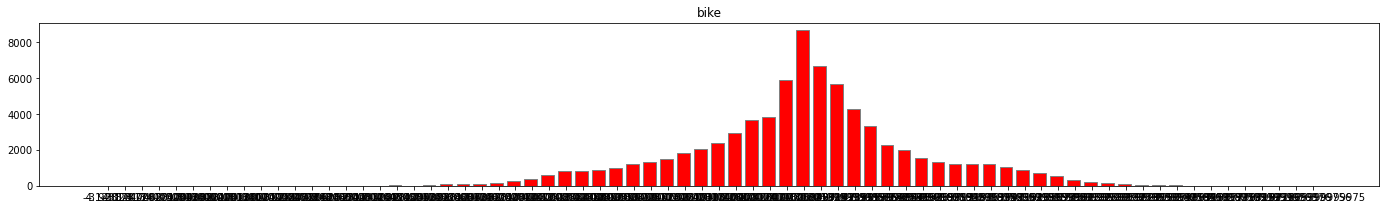

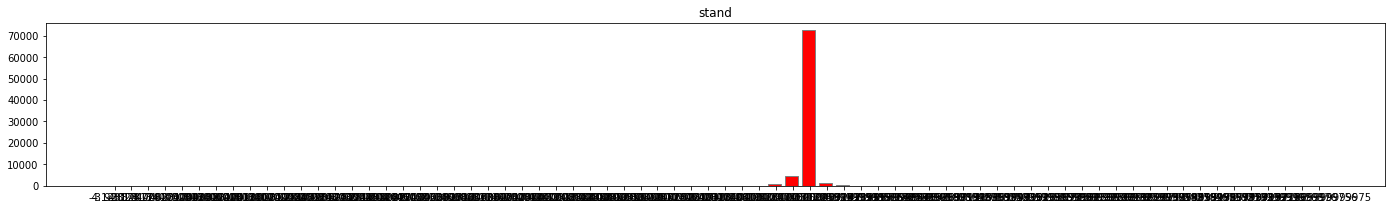

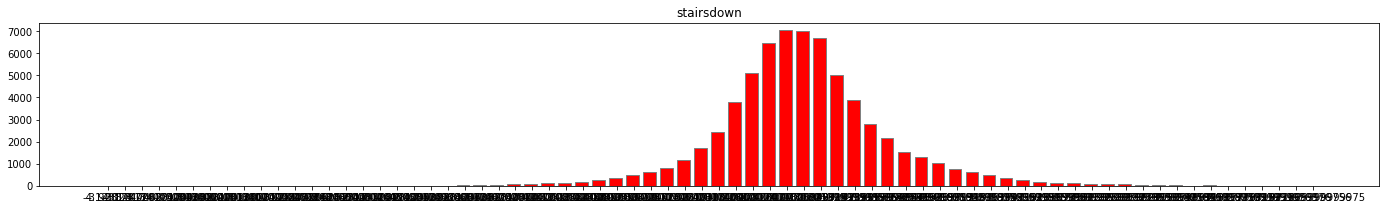

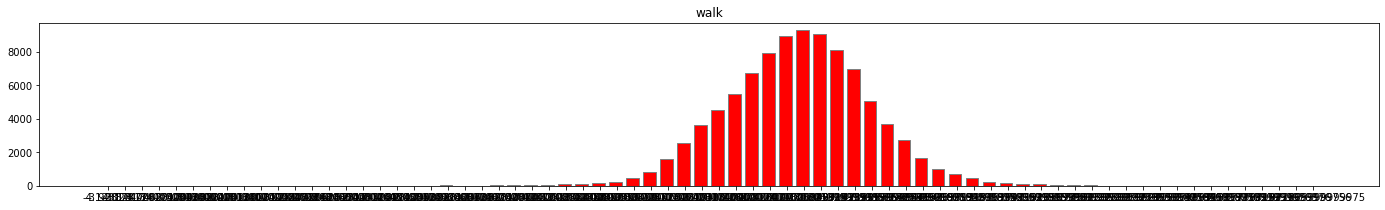

In [48]:
print("X Coordinates:\n")
size = int(np.ceil((x_max - x_min)/0.1))

for op in activities:
  x_intervals = [0 for _ in range(size)]
  xs = values_list(coordinates_data.filter(f.col("gt") == op).select("x").collect())
  for x in xs:
    x_intervals[int((x-x_min)/0.1)] += 1
  plot(x_intervals, np.arange(x_min, x_max, 0.1), in_color='red', size='l', with_label=op)

These graphs allow us to understand that for each activity, there exist x values that are more frequent than others. For example, for the "sit" and "stand" activities, the x value of each sample tend to be in regrouped in one particular value, whereas for the "strairsdown" activity althought that all the values regrouped in one area of value, they are more scattered.

Y Coordinates:



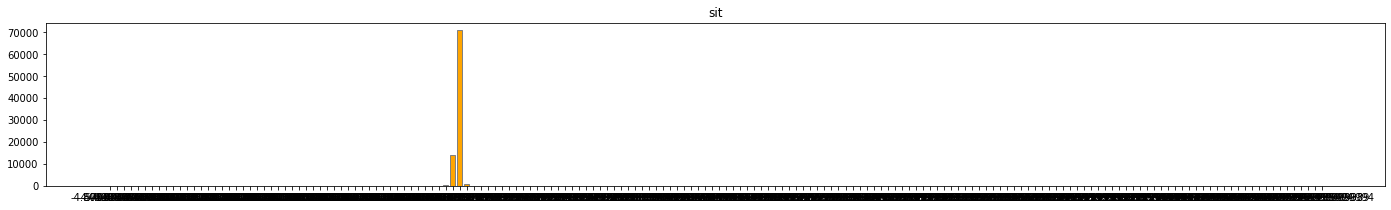

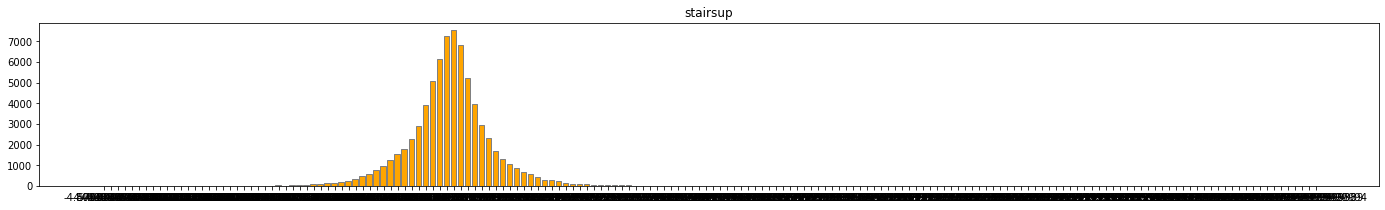

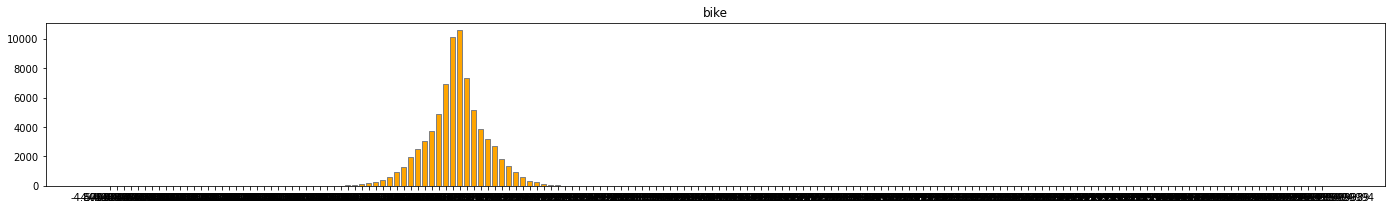

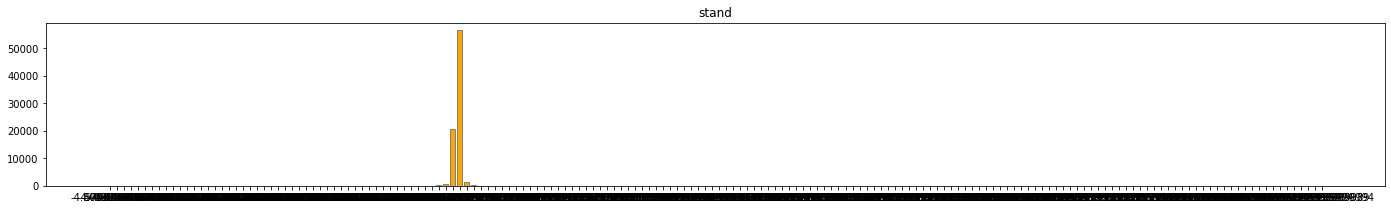

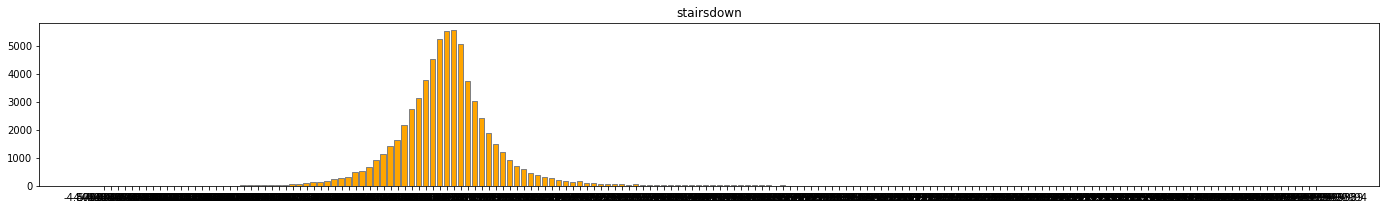

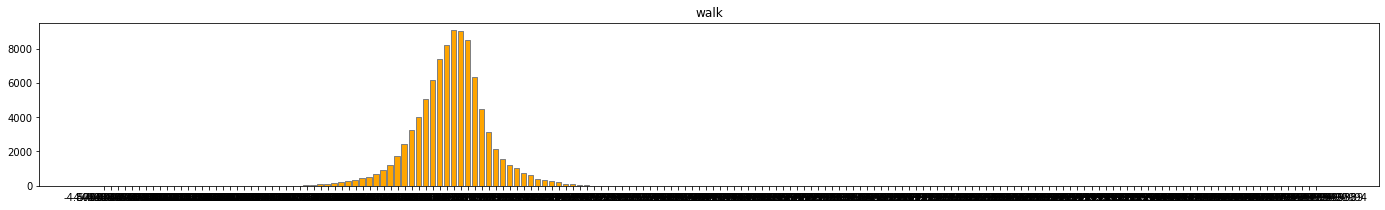

In [49]:
print("Y Coordinates:\n")
size = int(np.ceil((y_max - y_min)/0.1))

for op in activities:
  y_intervals = [0 for _ in range(size)]
  ys = values_list(coordinates_data.filter(f.col("gt") == op).select("y").collect())
  for y in ys:
    y_intervals[int((y-y_min)/0.1)] += 1
  plot(y_intervals, np.arange(y_min, y_max, 0.1), in_color='orange', size='l', with_label=op)

With the same idea, these graphs allow us to understand that for each activity, there exist y values that are more frequent than others. For example, for the "sit" and "stand" activities, the y value of each sample tend to be in regrouped in one particular value, whereas for the "strairsdown" activity althought that all the values regrouped in one area of value, they are more scattered.

Z Coordinates:



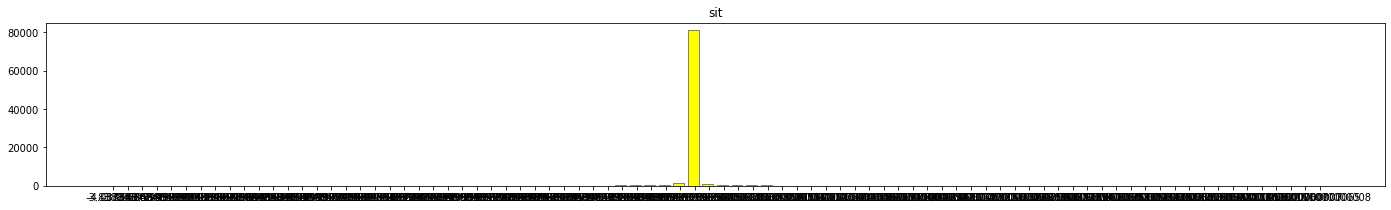

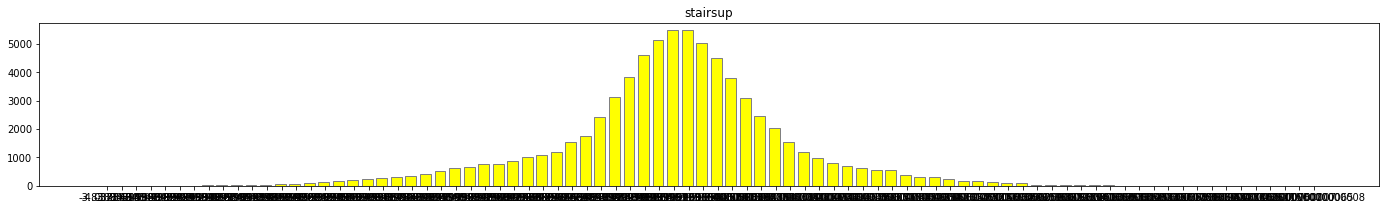

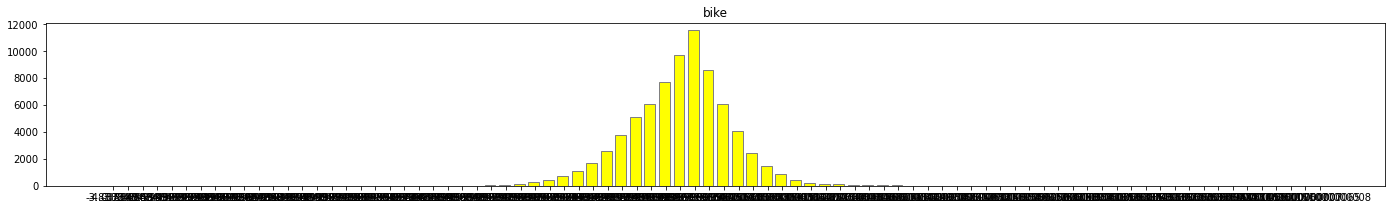

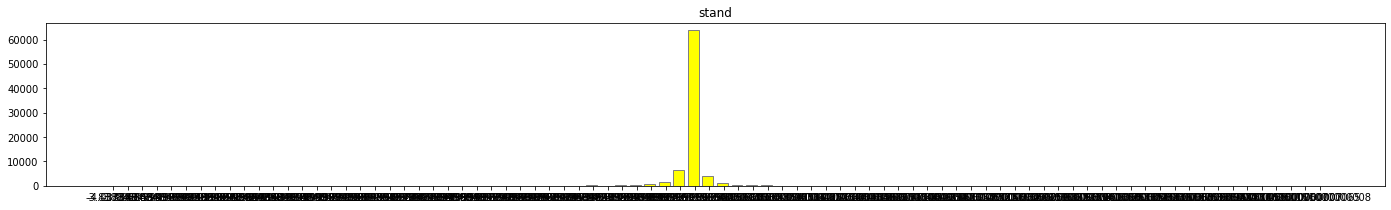

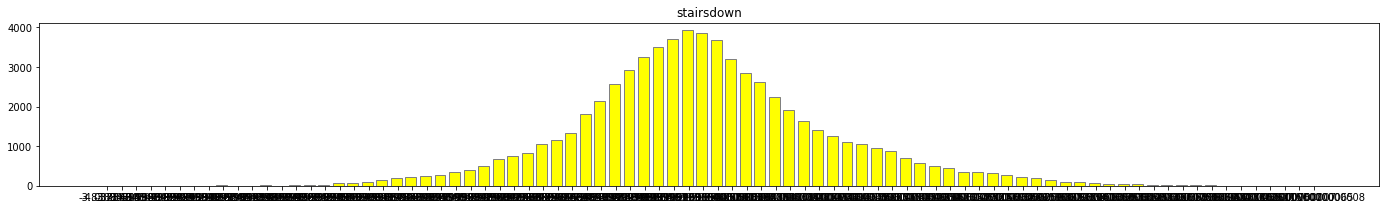

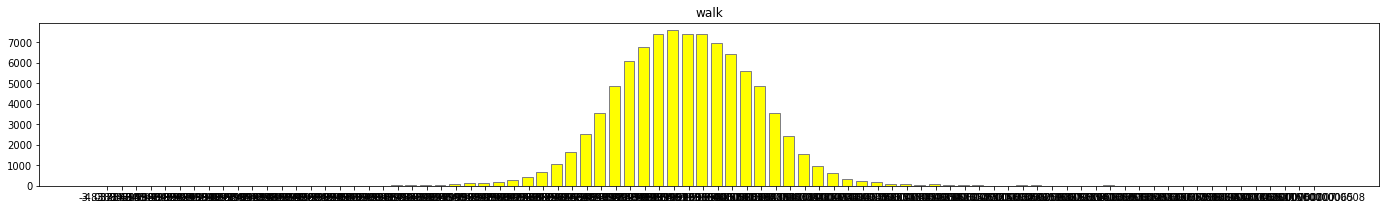

In [50]:
print("Z Coordinates:\n")

size = int(np.ceil((z_max - z_min)/0.1))

for op in activities:
  z_intervals = [0 for _ in range(size)]
  zs = values_list(coordinates_data.filter(f.col("gt") == op).select("z").collect())
  for z in zs:
    z_intervals[int((z-z_min)/0.1)] += 1
  plot(z_intervals, np.arange(z_min, z_max, 0.1), in_color='yellow', size='l', with_label=op)

Finally, again with the same idea, these graphs allow us to understand that for each activity, there exist z values that are more frequent than others. For example, for the "sit" and "stand" activities, the z value of each sample tend to be in regrouped in one particular value, whereas for the "strairsdown" activity althought that all the values regrouped in one area of value, they are more scattered.

3.1 **Relation between User and Creation Time**

In [51]:
def get_time(some_string):
  hours = int(some_string[-9:-6])
  minuts = int(some_string[-5:-3])
  return hours, minuts

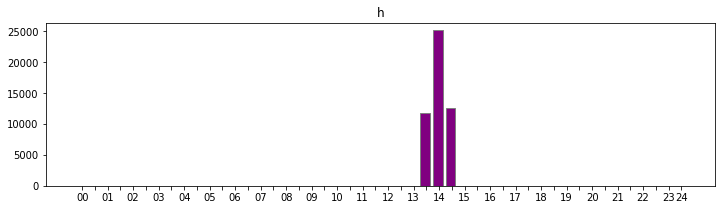

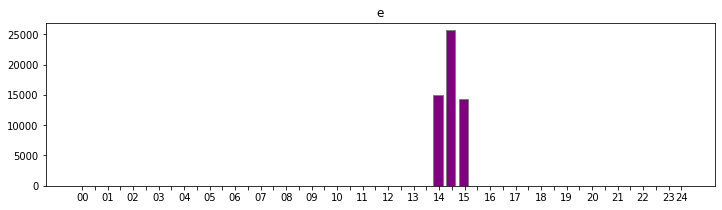

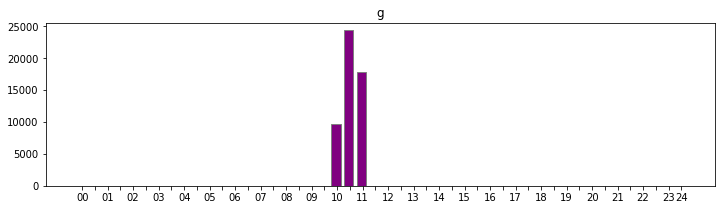

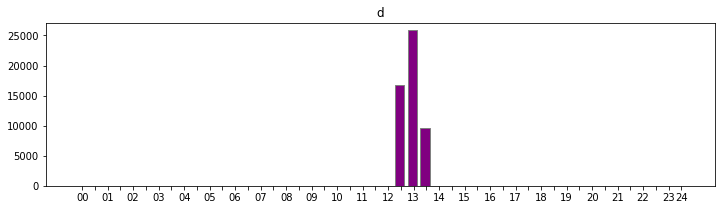

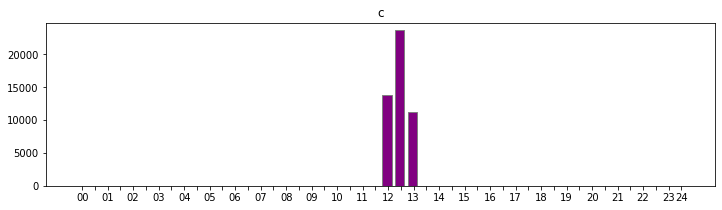

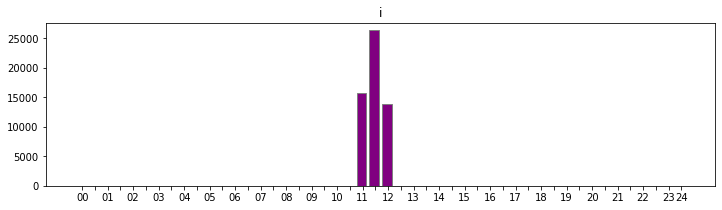

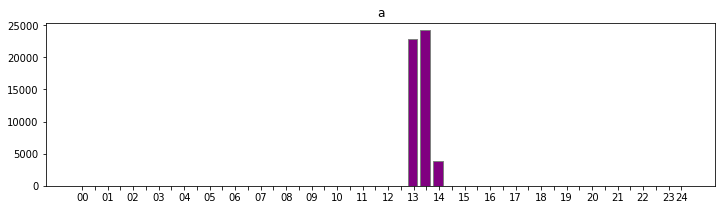

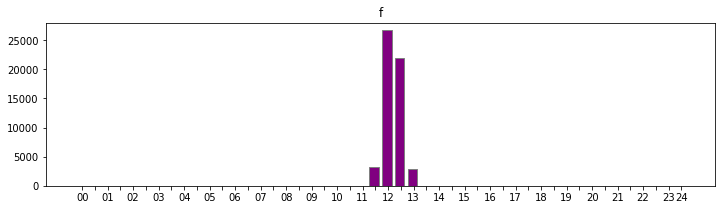

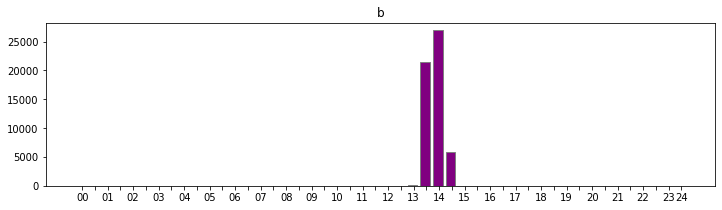

In [52]:
user_frequence = {}
time_data = time_data.drop('Index')
users = values_list(list(set(data.select("User").collect())))
intervals = [i*0.5 for i in range(1, 49)]
x_axis = ['0'+f"{i}" for i in range(10)] +  [f"{i}" for i in range(10, 25)]

for i in range(1, 24):
  x_axis.insert(2*i-1, '  ')

for letter in users:
  user_frequence[f"{letter}_data"] = time_data.filter(f.col("User") == letter)
  values = [0 for _ in range(1,49)]
  times = values_list(user_frequence[f"{letter}_data"].select("Creation_time_date").collect())

  for i in times:
    h,t = get_time(i)
    values[2*h + (t>30)] += 1
  plot(values, x_axis, in_color='purple',size='m', with_label = letter)

These graphs inform us on the time of the day that each user prefer to do any activity (based on the time of each sample of each user). We can learn in example that user d prefers to do his activities between 12:30 and 13:30, with a majority at 13:00, based on our data.

3.2 **Relation between Activity and Creation Time**

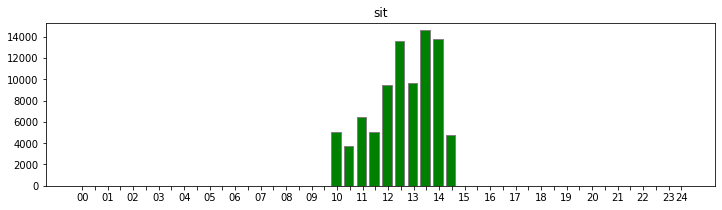

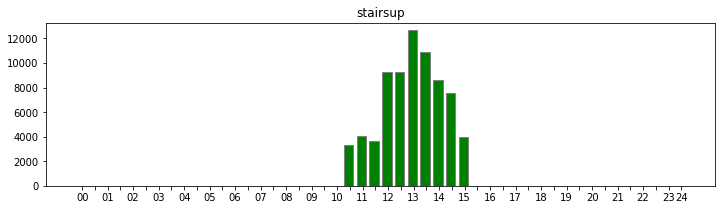

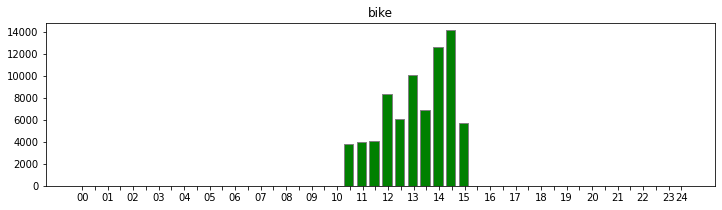

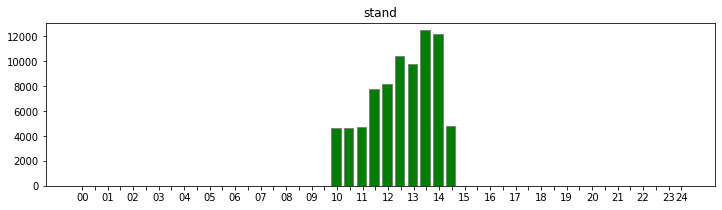

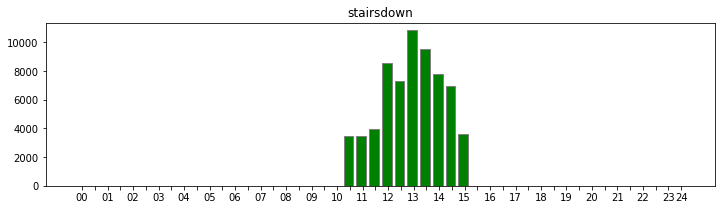

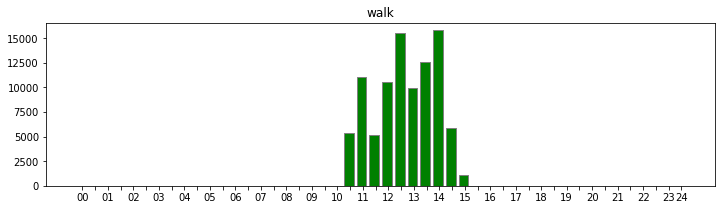

In [53]:
gt_frequence = {}
data_time = data.drop('x', 'y', 'z').drop('Index')
#activities = values_list(list(set(data.select("gt").collect())))
intervals = [i*0.5 for i in range(1, 49)]
x_axis = ['0'+f"{i}" for i in range(10)] +  [f"{i}" for i in range(10, 25)]

for i in range(1, 24):
  x_axis.insert(2*i-1, '  ')

for gt in activities:
  gt_frequence[f"{gt}_data"] = data_time.filter(f.col("gt") == gt)
  values = [0 for _ in range(1,49)]
  times = values_list(gt_frequence[f"{gt}_data"].select("Creation_time_date").collect())

  for i in times:
    h,t = get_time(i)
    values[2*h + (t>30)] += 1
  plot(values, x_axis, in_color='green',size='m', with_label = gt)

These graphs inform us on the time of the day that users prefer to do a particular activity. 
We can learn that in general users usually do any activity between 9:30 and 15. 
More specifically, if we take the "sit activity" in example, users prefer to do it between 10 and 14:30, with a majority of users between 13:30 and 14:00.

*In conclusion* of this part, with our analysis we can derive 3 insight from our data that will help us in the next parts : The importance of each coordinate and the relation of each axe value (x, y, z values) with regard to the activity analysed; The relation between each user and the type of activity relied to him; The relation between the Creation Time of each sample (when the activity was begining),the user and the activity (inform us on what time of the day each user is more regular to do each activity).

In [ ]:
%%shell
jupyter nbconvert --to html /content/project2_part1_342791324_329803506_345233563.ipynb